# Predicting Heart Disease

**Authors: Elnaz Azizi, Charly Watts, Christian Unterrainer**

## 1. Introduction & Objective

This notebook aims to predict the presence of heart disease using machine learning techniques. We will be working with three publicly available datasets: Cleveland, Switzerland, and Hungarian. 

**Objective:**
The primary goal is to build, evaluate, and compare several classification models:
1. Logistic Regression (Baseline)
2. K-Nearest Neighbors (KNN) (Baseline)
3. Gaussian Naive Bayes (Baseline)
4. Gradient Boosting Classifier
5. MLP Classifier (Neural Network)
6. Random Forest Classifier

We will employ appropriate data preprocessing steps, including imputation and scaling. Model evaluation will focus on the F1-score for the positive class (presence of heart disease), given its suitability for potentially imbalanced datasets where both precision and recall are important. Two main evaluation strategies will be explored:
- **Nested Cross-Validation:** To obtain a robust and unbiased estimate of model generalization performance.
- **Train/Test Split with GridSearchCV & Threshold Optimization:** To identify a specific "best" model configuration and optimize its decision threshold for the F1-score.

The notebook will walk through data loading, exploratory data analysis (EDA), preprocessing, model pipeline definition, evaluation, and finally, visualization and discussion of the results.

## 2. Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, f1_score

## 3. Data Loading and Initial Overview

### 3.1. Load Data from Files
We load three datasets: Cleveland, Switzerland, and Hungarian. Missing values are denoted by '?' in the raw files. The Hungarian dataset is space-separated, while the others are comma-separated, requiring different parsing strategies.

In [40]:
# List of tuples: (filepath, is_space_separated)
# Used to load multiple datasets with potentially different separators
file_info = [
    ('data/processed.cleveland.data', False),
    ('data/processed.switzerland.data', False),
    ('data/reprocessed.hungarian.data', True),  # space-separated
]

# Column names for the dataset(s); assumed to be the same across all files
col_names = [
    'age','sex','cp','trestbps','chol','fbs',
    'restecg','thalach','exang','oldpeak',
    'slope','ca','thal','target'
]

# List to hold the individual dataframes after loading
dataframes = []
df_names = ['Cleveland', 'Switzerland', 'Hungarian'] # For easier referencing

# Loop through each file and load it into a pandas DataFrame
for path, is_space_separated in file_info:
    if is_space_separated:
        # Use regex separator for space-separated values (e.g., Hungarian dataset)
        df = pd.read_csv(path, sep=r'\s+', header=None, names=col_names, na_values='?')
    else:
        # Default CSV reading (assumes comma-separated or consistent with pd default)
        df = pd.read_csv(path, header=None, names=col_names, na_values='?')
    dataframes.append(df)  # Store the loaded DataFrame

### 3.2. Initial Data Inspection
Let's get a first look at the structure, data types, and missing values for each dataset.

In [41]:
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- {df_name} Dataset ---")
    print("--- First 5 Rows ---")
    print(df.head())
    print("\n--- Data Info ---")
    df.info()
    print("\n--- Missing Values (Count) ---")
    print(df.isnull().sum())
    print("\n--- Descriptive Statistics (Numeric Features) ---")
    print(df.describe())


--- Cleveland Dataset ---
--- First 5 Rows ---
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       2  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null  

**Initial Observations:**
- All columns are initially read as `float64` or `int64` by pandas where possible, with `object` types where '?' (NaNs) are present in otherwise numeric columns.
- Several columns contain missing values (NaNs), notably 'ca' and 'thal' across multiple datasets, and others like 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope' in the Hungarian and/or Swiss datasets.
- The scale of numeric features varies (e.g., 'age' vs 'chol'), suggesting that feature scaling will be necessary.

## 4. Exploratory Data Analysis (EDA)
In this section, we'll dive deeper into the characteristics of each dataset. For brevity in this structured example, we'll show placeholder code for plots. In a real analysis, these would be generated and interpreted for each dataset.

### 4.1. Target Variable Distribution
Understanding the distribution of the target variable (presence or absence of heart disease) is crucial, especially for assessing class imbalance before its transformation.

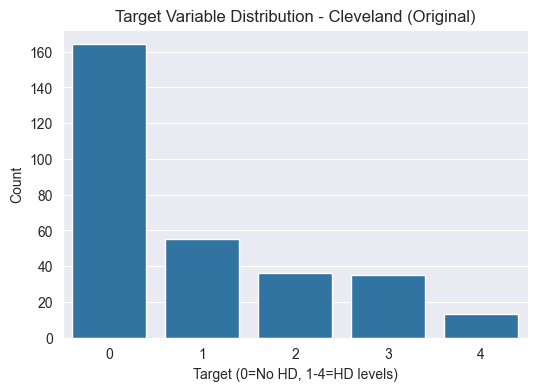

target
0    0.541254
1    0.181518
2    0.118812
3    0.115512
4    0.042904
Name: proportion, dtype: float64


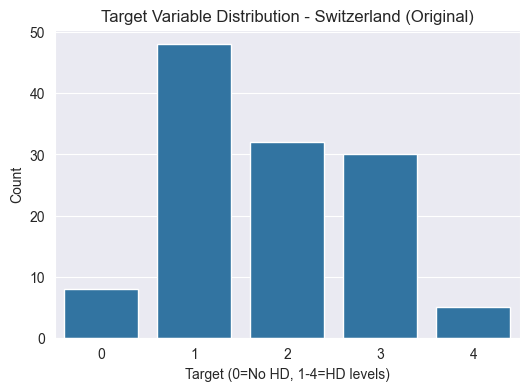

target
0    0.065041
1    0.390244
2    0.260163
3    0.243902
4    0.040650
Name: proportion, dtype: float64


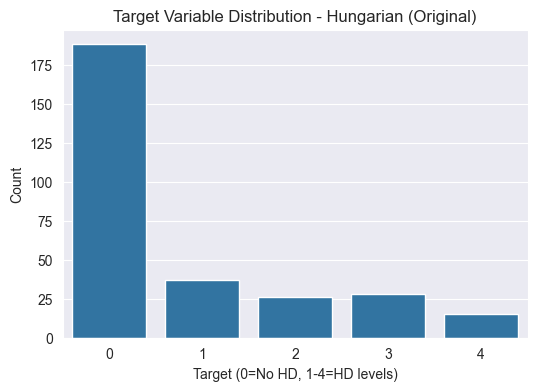

target
0    0.639456
1    0.125850
2    0.088435
3    0.095238
4    0.051020
Name: proportion, dtype: float64


In [42]:
for df_name, df in zip(df_names, dataframes):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x='target')
    plt.title(f'Target Variable Distribution - {df_name} (Original)')
    plt.xlabel('Target (0=No HD, 1-4=HD levels)')
    plt.ylabel('Count')
    plt.show()
    print(df['target'].value_counts(normalize=True).sort_index())

**Target Variable Interpretation:**
- The original target variable has multiple levels indicating the degree of heart disease. We will later binarize this (0 for no disease, 1 for any presence of disease).
- The Cleveland dataset appears to have a reasonable balance between 'no disease' (value 0) and 'presence of disease' (values > 0).
- The Swiss and Hungarian datasets show a higher prevalence of 'no disease' (value 0) in their raw forms.

### 4.2. Numerical Feature Distributions
Histograms or boxplots help understand the distribution, skewness, and potential outliers in numerical features.


--- Numerical Feature Distributions for Cleveland ---


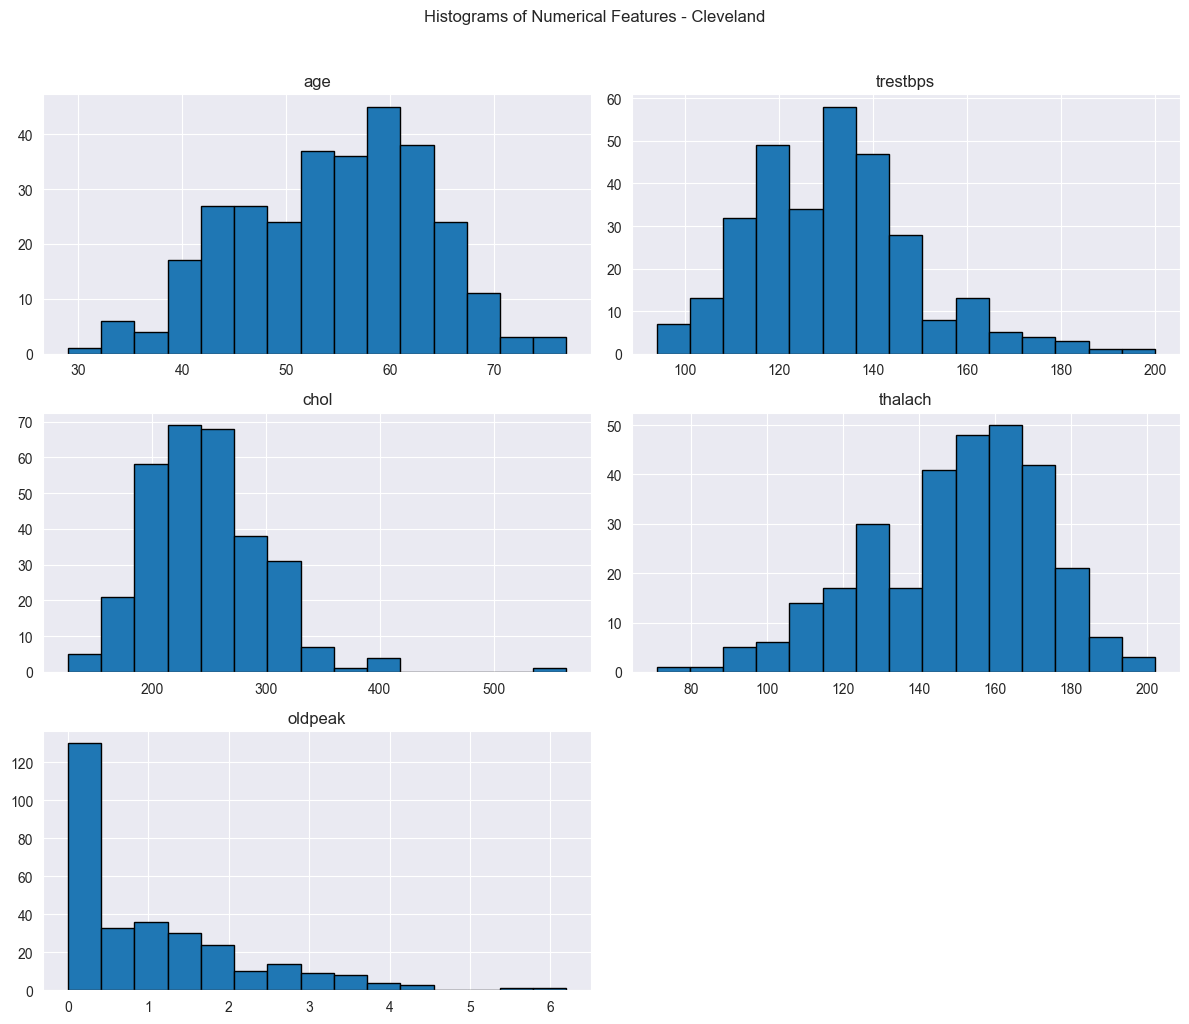


--- Numerical Feature Distributions for Switzerland ---


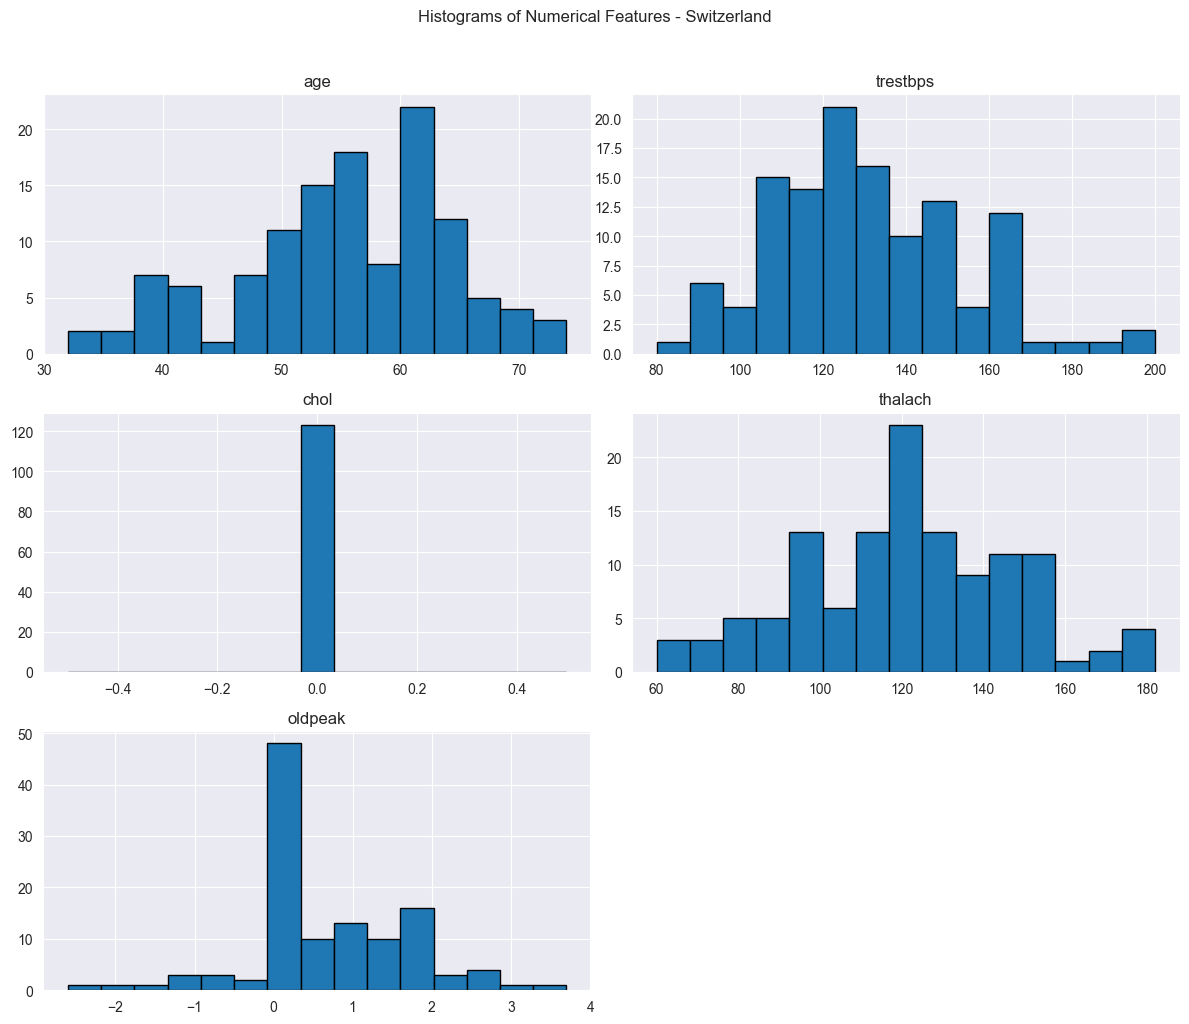


--- Numerical Feature Distributions for Hungarian ---


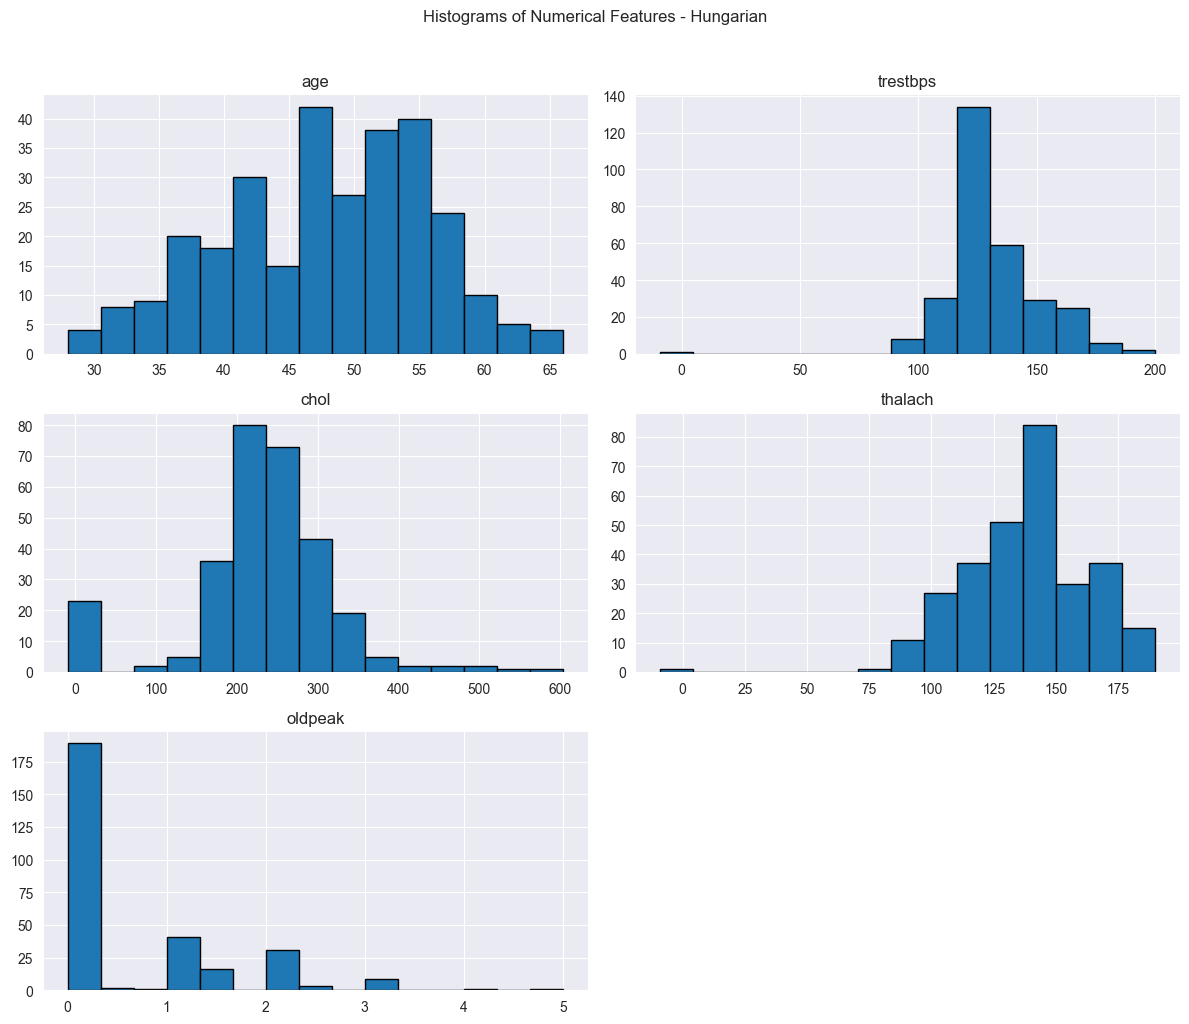

In [43]:
numeric_cols_eda = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak'] # From original notebook
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- Numerical Feature Distributions for {df_name} ---")
    df[numeric_cols_eda].hist(figsize=(12, 10), bins=15, edgecolor='black')
    plt.suptitle(f'Histograms of Numerical Features - {df_name}', y=1.02)
    plt.tight_layout()
    plt.show()

**Numerical Feature Interpretation:**
- **Age:** Appears roughly normally distributed across datasets.
- **trestbps (Resting Blood Pressure):** Generally centered, some right skew possible.
- **chol (Serum Cholesterol):** Can be right-skewed. Note the Swiss dataset has many missing 'chol' values, and some datasets might have placeholder zeros that need to be treated as NaNs if not already.
- **thalach (Max Heart Rate Achieved):** Varies, might be somewhat left-skewed.
- **oldpeak (ST Depression):** Often right-skewed.

### 4.3. Categorical Feature Distributions
Bar charts show the frequency of each category within categorical features.


--- Categorical Feature Distributions for Cleveland ---


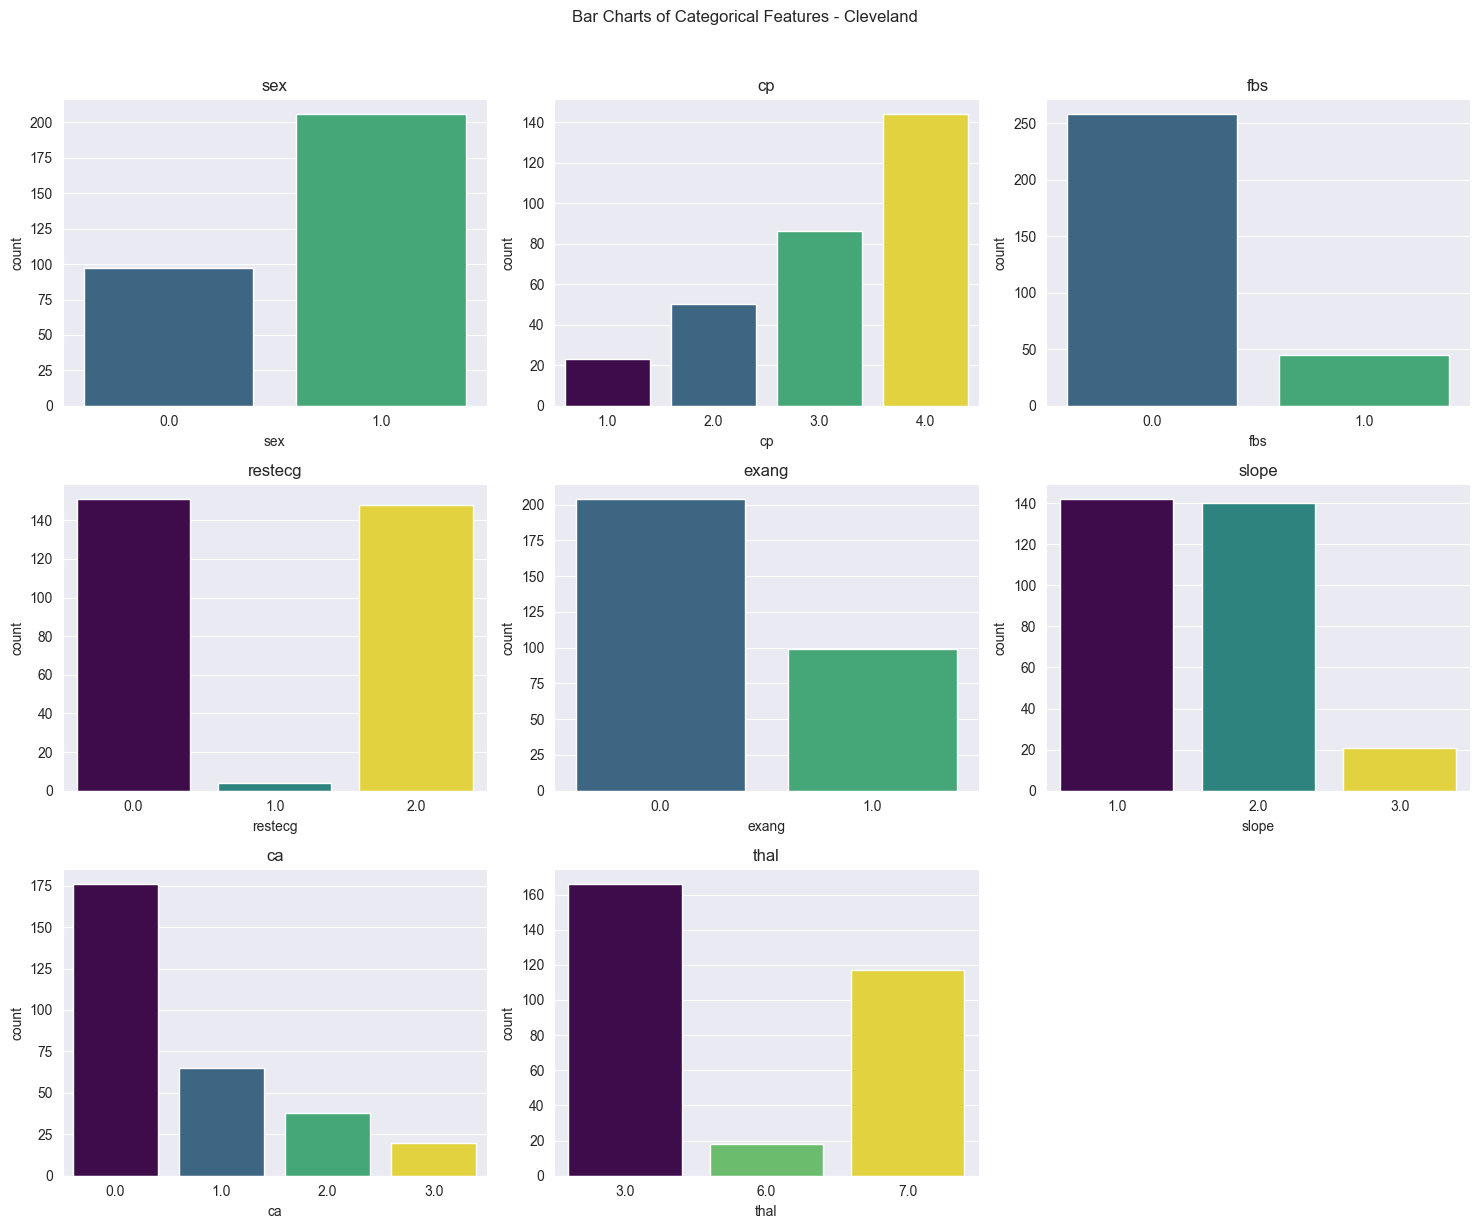


--- Categorical Feature Distributions for Switzerland ---


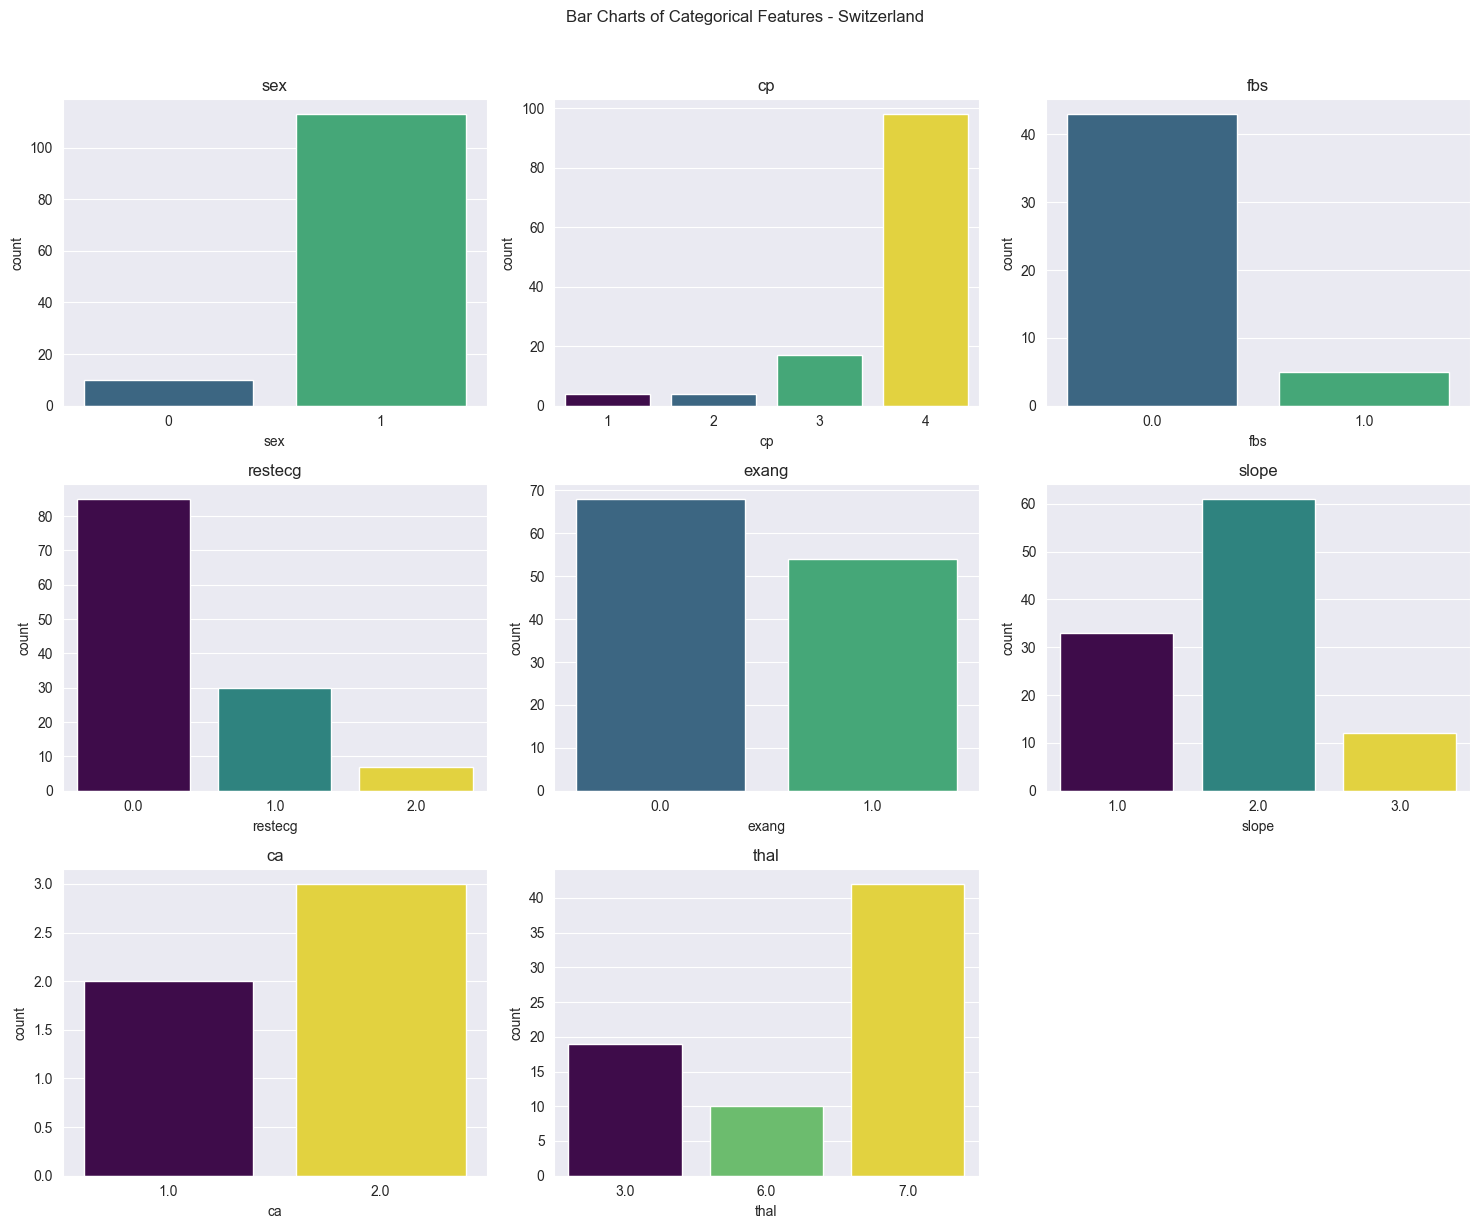


--- Categorical Feature Distributions for Hungarian ---


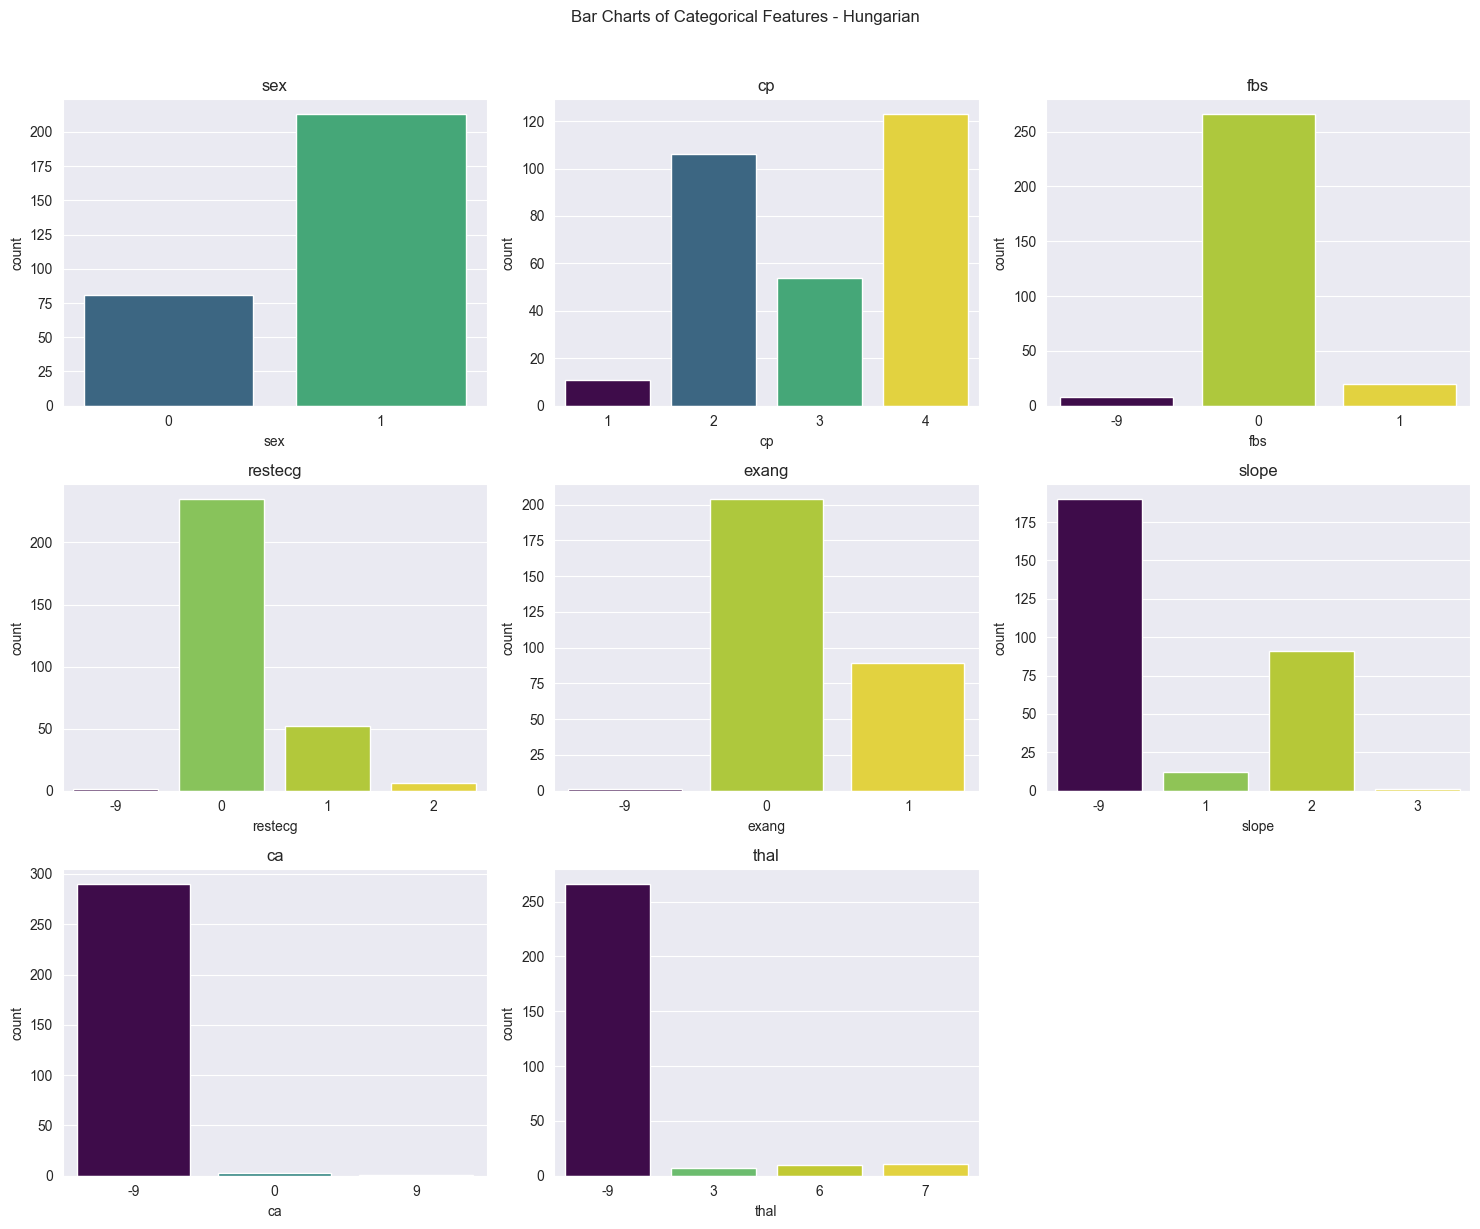

In [44]:
categorical_cols_eda = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'] # From original notebook
for df_name, df in zip(df_names, dataframes):
    print(f"\n--- Categorical Feature Distributions for {df_name} ---")
    fig, axes = plt.subplots(math.ceil(len(categorical_cols_eda)/3), 3, figsize=(15, 12))
    axes = axes.flatten()
    for i, col in enumerate(categorical_cols_eda):
        sns.countplot(data=df, x=col, hue=col, ax=axes[i], palette='viridis', legend=False)
        axes[i].set_title(col)
    plt.suptitle(f'Bar Charts of Categorical Features - {df_name}', y=1.02)
    plt.tight_layout()
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.show()

**Categorical Feature Interpretation:**
- Distributions vary across datasets. For example, 'ca' (number of major vessels colored by flouroscopy) and 'thal' (thalassemia type) have a significant number of missing values in some datasets, which will be handled by imputation.

### 4.4. Correlation Analysis
A heatmap of correlations between numerical features can reveal multicollinearity or strong relationships with the target (once binarized).


--- Correlation Matrix for Cleveland (Numerical Features) ---


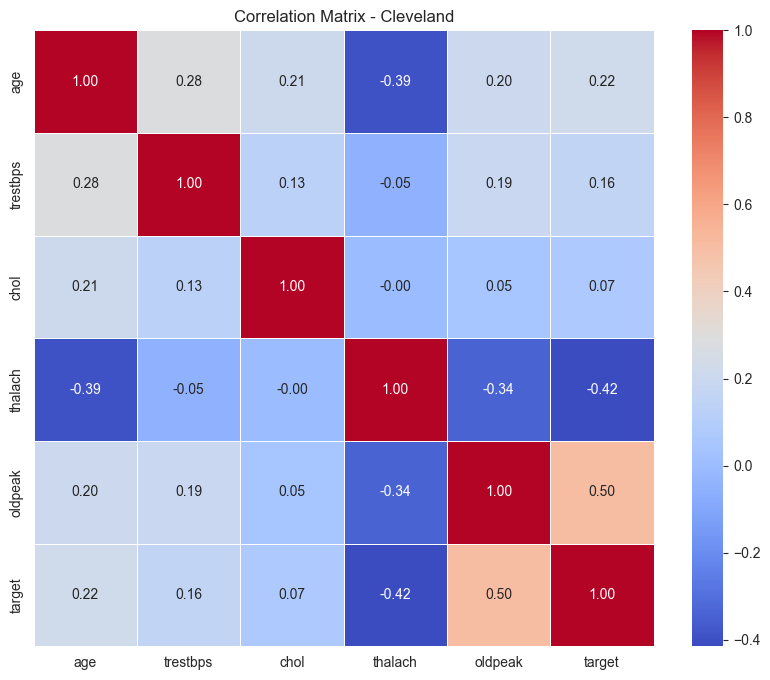


--- Correlation Matrix for Switzerland (Numerical Features) ---


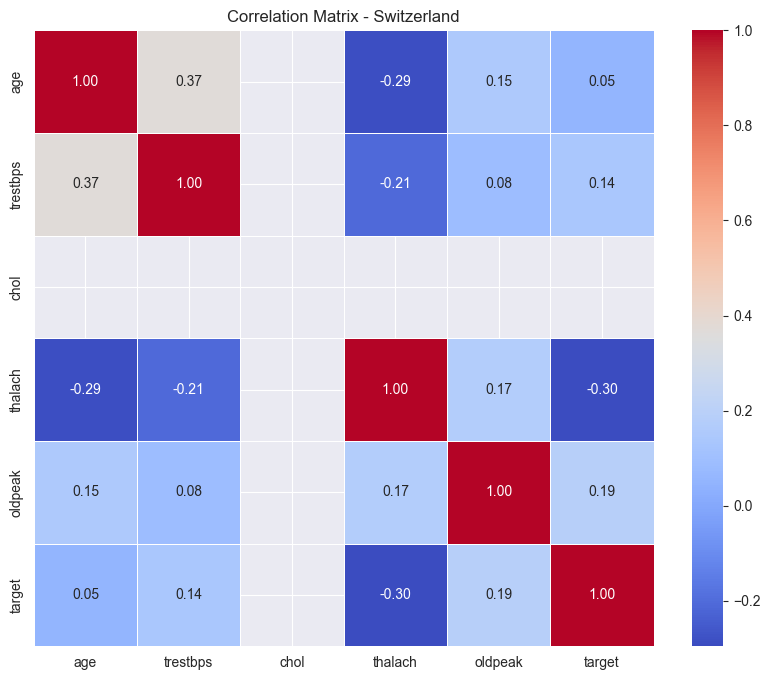


--- Correlation Matrix for Hungarian (Numerical Features) ---


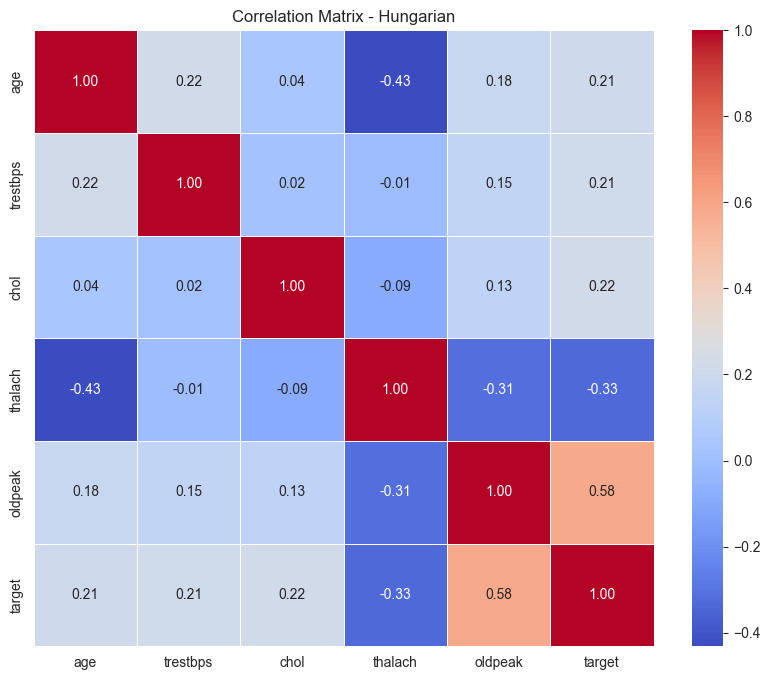

In [45]:
for df_name, df_orig in zip(df_names, dataframes):
    print(f"\n--- Correlation Matrix for {df_name} (Numerical Features) ---")
    df = df_orig.copy() # Work on a copy for this EDA step
    df_numeric_for_corr = df[numeric_cols_eda + ['target']].apply(pd.to_numeric, errors='coerce')
    
    plt.figure(figsize=(10, 8))
    correlation_matrix = df_numeric_for_corr.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(f'Correlation Matrix - {df_name}')
    plt.show()

**Correlation Interpretation:**
- Observe any strong positive or negative correlations between features. High multicollinearity (e.g., > 0.8 or < -0.8) between independent features might be a concern for some models like Logistic Regression, though modern implementations are often robust.
- Correlations with the 'target' variable (after its binarization) would indicate feature predictiveness.

### 4.5. EDA Summary & Impact on Preprocessing
- **Missing Values:** Significant missing data in features like 'ca', 'thal', and others confirm the need for imputation. The choice of median for numeric and most_frequent for categorical seems reasonable as a baseline.
- **Feature Scaling:** Varying scales of numeric features ('age', 'chol', 'oldpeak') necessitate standardization.
- **Skewness:** Some numeric features ('chol', 'oldpeak') exhibit skewness, making median imputation generally more robust than mean imputation.
- **Categorical Encoding:** Categorical features are numerically encoded but represent distinct categories. While `SimpleImputer` handles them, more advanced models might benefit from one-hot encoding if nominal, or ordinal encoding if ordinal (though not explicitly done in this pipeline for simplicity with baseline models).

## 5. Data Preparation for Modeling

### 5.1. Target Variable Transformation and Train-Test Split
For each dataset:
1. The target variable (originally multi-class indicating severity) is converted to a binary format (0: no heart disease, 1: presence of any heart disease).
2. The data is split into training (80%) and testing (20%) sets.
3. Stratification is used on the binarized target variable (`y`) to ensure that class proportions are maintained in both training and testing sets. This is important for reliable model evaluation, especially if class imbalance exists.
4. `random_state=42` ensures that the data split is the same every time the code is run, making results reproducible.
5. NaNs are intentionally kept at this stage; they will be handled by imputation steps within the machine learning pipeline to prevent data leakage from the test set into the training process.

In [46]:
# Prepare train/test split for each dataset
# Note: NaNs are intentionally kept for later imputation in the ML pipeline
splits = []

# Iterate over each DataFrame and corresponding file info
for df, (path, _) in zip(dataframes, file_info):
    dataset_name_from_path = path.split('/')[-1] 

    df['target'] = df['target'].astype(int).apply(lambda v: 1 if v > 0 else 0)

    x = df.drop(columns='target')
    y = df['target']

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.2, 
        random_state=42, 
        stratify=y 
    )

    splits.append({
        "dataset": dataset_name_from_path,
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test
    })
    
    print(f"\n--- Target distribution in {dataset_name_from_path} after binarization and split ---")
    print(f"--- {dataset_name_from_path} (Original Dataset Proportions Before Split) ---")
    print(y.value_counts(normalize=True).sort_index())
    print(f"--- {dataset_name_from_path} (Train Set Proportions) ---")
    print(y_train.value_counts(normalize=True).sort_index())
    print(f"--- {dataset_name_from_path} (Test Set Proportions) ---")
    print(y_test.value_counts(normalize=True).sort_index())


--- Target distribution in processed.cleveland.data after binarization and split ---
--- processed.cleveland.data (Original Dataset Proportions Before Split) ---
target
0    0.541254
1    0.458746
Name: proportion, dtype: float64
--- processed.cleveland.data (Train Set Proportions) ---
target
0    0.541322
1    0.458678
Name: proportion, dtype: float64
--- processed.cleveland.data (Test Set Proportions) ---
target
0    0.540984
1    0.459016
Name: proportion, dtype: float64

--- Target distribution in processed.switzerland.data after binarization and split ---
--- processed.switzerland.data (Original Dataset Proportions Before Split) ---
target
0    0.065041
1    0.934959
Name: proportion, dtype: float64
--- processed.switzerland.data (Train Set Proportions) ---
target
0    0.061224
1    0.938776
Name: proportion, dtype: float64
--- processed.switzerland.data (Test Set Proportions) ---
target
0    0.08
1    0.92
Name: proportion, dtype: float64

--- Target distribution in reprocessed.

### 5.2. Feature Column Configuration
Define numeric and categorical columns for applying distinct preprocessing steps.

In [47]:
# Define feature column types
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

### 5.3. Preprocessing Pipeline Definition
- **Numeric Features:** Missing values are imputed using the `median` strategy, which is robust to outliers. Subsequently, features are scaled using `StandardScaler` to have zero mean and unit variance, which benefits models like Logistic Regression and KNN.
- **Categorical Features:** Missing values are imputed using the `most_frequent` value in each column. `add_indicator=True` creates an additional binary column for each imputed categorical feature, indicating whether the value was imputed or original. This can sometimes provide useful information to the model.

In [48]:
# Numeric preprocessing: impute missing values, then scale
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute with most frequent value, add missingness indicator
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

# Combine both into a column transformer
preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols),
    ('cat', cat_pipe, categorical_cols)
])

## 6. Modeling Pipeline Definition

### 6.1. Full Model Pipelines
Each model pipeline integrates the preprocessor defined above with the respective classifier. A `random_state` is added to Logistic Regression, Gradient Boosting, MLP Classifier, and Random Forest for reproducibility.

In [49]:
# Logistic Regression pipeline
logistic_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, random_state=42)) 
])

# KNN pipeline
kneighbors_pipeline = Pipeline([
    ('pre', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Naive Bayes pipeline
naive_pipeline = Pipeline([
    ('pre', preprocessor),
    ('nav', GaussianNB())
])

# Gradient Boosting pipeline
gradient_boosting_pipeline = Pipeline([
    ('pre', preprocessor),
    ('gbc', GradientBoostingClassifier(random_state=42))
])

# MLP (Neural Network) pipeline
mlp_pipeline = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPClassifier(random_state=42, max_iter=1000)) 
])

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestClassifier(random_state=42))
])

### 6.2. Hyperparameter Grids
Define hyperparameter search spaces for Logistic Regression, KNN, Gradient Boosting, MLP, and Random Forest. Gaussian Naive Bayes has no significant hyperparameters to tune in this context. These grids are starting points and can be expanded for more exhaustive tuning.

In [50]:
logistic_param_grid = {'clf__C': [0.01, 0.1, 1, 10]}
kneighbors_param_grid = {'knn__n_neighbors': list(range(1, 21))}
naive_param_grid = {} 

gradient_boosting_param_grid = {
    'gbc__n_estimators': [100, 200], 
    'gbc__learning_rate': [0.05, 0.1],
    'gbc__max_depth': [3, 5],
    'gbc__subsample': [0.8], 
    'gbc__min_samples_split': [5],
    'gbc__min_samples_leaf': [3]
}

mlp_param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100, 50)], 
    'mlp__activation': ['relu'], 
    'mlp__solver': ['adam'], 
    'mlp__alpha': [0.001, 0.01],
    'mlp__learning_rate_init': [0.001],
    'mlp__early_stopping': [True],
    'mlp__n_iter_no_change': [10]
}

rf_param_grid = {
    'rf__n_estimators' : [100, 200], 
    'rf__max_depth' : [None, 10, 20], 
    'rf__min_samples_split' : [2, 5], 
    'rf__min_samples_leaf' : [1, 2],
    'rf__class_weight': ['balanced', 'balanced_subsample', None]
}

### 6.3. Model Configurations Dictionary
We define a dictionary to hold the common pipelines and parameter grids for easier iteration during evaluation, now including Gradient Boosting, MLP, and Random Forest.

In [51]:
model_configurations = {
    "Logistic Regression": (logistic_pipeline, logistic_param_grid),
    "K Nearest Neighbors": (kneighbors_pipeline, kneighbors_param_grid),
    "Naive Bayes": (naive_pipeline, naive_param_grid),
    "Gradient Boosting": (gradient_boosting_pipeline, gradient_boosting_param_grid),
    "MLP Classifier": (mlp_pipeline, mlp_param_grid),
    "Random Forest": (rf_pipeline, rf_param_grid)
}

## 7. Model Evaluation Strategies

### 7.1. Nested Cross-Validation for Robust Performance Estimation
Nested Cross-Validation (CV) provides a more reliable and less biased estimate of how well our model (including its hyperparameter tuning process) will generalize to unseen data.
- The **outer loop** of the CV splits the entire dataset into several folds (e.g., 5 folds). For each outer fold, one part is held out as a test set, and the rest is used for training.
- The **inner loop** is performed on the training part of each outer fold. Inside this inner loop, `GridSearchCV` is used to find the best hyperparameters for the model. This means the hyperparameter tuning is done without seeing the outer loop's test set.
- The performance metric (F1-score in our case) is then evaluated on the outer loop's test set using the model trained with the best hyperparameters found in the inner loop.
- The final result is an average of the F1-scores obtained from each fold of the outer loop. This approach helps prevent overly optimistic performance estimates that can occur if hyperparameters are tuned and the model is evaluated on the same test data.

In [52]:
nested_cv_results_summary = []

for split_data in splits: 
    dataset_name = split_data["dataset"]
    print(f"Running Nested CV for dataset: {dataset_name}")

    X_full = pd.concat([split_data["x_train"], split_data["x_test"]], ignore_index=True)
    y_full = pd.concat([split_data["y_train"], split_data["y_test"]], ignore_index=True)

    for model_name, (pipeline, param_grid) in model_configurations.items():
        print(f"  Model: {model_name}")
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) 
        grid_search_cv = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring='f1', n_jobs=-1)
        outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
        nested_f1_scores = cross_val_score(grid_search_cv, X_full, y_full, cv=outer_cv, scoring='f1', n_jobs=-1)

        nested_cv_results_summary.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Nested F1 Mean": nested_f1_scores.mean(),
            "Nested F1 Std": nested_f1_scores.std()
        })

nested_cv_df = pd.DataFrame(nested_cv_results_summary)
print("\n--- Nested Cross-Validation Results Summary ---")
print(nested_cv_df)

Running Nested CV for dataset: processed.cleveland.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest
Running Nested CV for dataset: processed.switzerland.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest
Running Nested CV for dataset: reprocessed.hungarian.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest

--- Nested Cross-Validation Results Summary ---
                       Dataset                Model  Nested F1 Mean  \
0     processed.cleveland.data  Logistic Regression        0.777559   
1     processed.cleveland.data  K Nearest Neighbors        0.768130   
2     processed.cleveland.data          Naive Bayes        0.699538   
3     processed.cleveland.data    Gr

**Nested CV Interpretation (Example):**
- The 'Nested F1 Mean' provides a robust estimate of how each model is expected to perform on new, unseen data from the respective dataset, after hyperparameter tuning.
- The 'Nested F1 Std' indicates the variability of this performance. A lower standard deviation suggests more consistent performance across different data subsets.

### 7.2. Train/Test Split with GridSearchCV & Threshold Optimization (Classic Approach)
This approach involves a more standard workflow:
1.  Data is split once into a training set and a test set (performed in section 5.1).
2.  Hyperparameter tuning using `GridSearchCV` is performed exclusively on the **training set**. The original notebook used `scoring='recall'` for `GridSearchCV`. This might be chosen to prioritize the model's ability to identify positive cases (patients with heart disease) during the hyperparameter selection phase, even if it leads to more false positives at this stage.
3.  The best model (pipeline with optimized hyperparameters) found by `GridSearchCV` is then used to predict probabilities for the positive class on the **test set**.
4.  The classification **decision threshold** (default is 0.5) is then optimized using the predicted probabilities from the test set. The goal here is to find a threshold that maximizes the F1-score for the positive class. *Note: Optimizing the threshold on the test set itself can lead to a slightly optimistic F1-score for that specific test set. Ideally, this optimization should be done on a separate validation set if data permits.*
5.  The final model performance (F1-score, precision, recall, confusion matrix) is reported on the test set using this optimized threshold.

This method gives us a single "best" model and its associated predictions per dataset, which is useful for more detailed analyses like generating P-R curves and confusion matrices for a specific model instance.

In [53]:
detailed_classic_results = []

for split_data in splits:
    dataset_name = split_data["dataset"]
    x_train = split_data["x_train"]
    y_train = split_data["y_train"]
    x_test = split_data["x_test"]
    y_test = split_data["y_test"]
    print(f"\nRunning Classic Approach for dataset: {dataset_name}")

    for model_name, (pipeline, param_grid) in model_configurations.items():
        print(f"  Model: {model_name}")
        grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1) # cv=3 for speed
        grid.fit(x_train, y_train)

        y_probs = grid.predict_proba(x_test)[:, 1]

        precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_probs)
        f1_scores_pr = 2 * (precisions * recalls) / (precisions + recalls + 1e-10) 
        
        if len(f1_scores_pr) > len(thresholds_pr):
             best_idx_pr = np.argmax(f1_scores_pr[:-1]) 
        else:
             best_idx_pr = np.argmax(f1_scores_pr)
        
        best_threshold = thresholds_pr[best_idx_pr]
        
        y_pred = (y_probs >= best_threshold).astype(int)

        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)

        detailed_classic_results.append({
            "Dataset": dataset_name,
            "Model": model_name,
            "Best Estimator": grid.best_estimator_,
            "Best Params (from GridSearchCV)": grid.best_params_,
            "Optimized Threshold": best_threshold,
            "Recall (Class 1, Opt Thresh)": report_dict.get('1', {}).get('recall', 0),
            "Precision (Class 1, Opt Thresh)": report_dict.get('1', {}).get('precision', 0),
            "F1-Score (Class 1, Opt Thresh)": report_dict.get('1', {}).get('f1-score', 0),
            "Confusion Matrix": cm,
            "y_test": y_test,
            "y_probs": y_probs,
            "y_pred_optimized_thresh": y_pred,
            "precisions_pr": precisions, 
            "recalls_pr": recalls,       
            "f1_scores_pr": f1_scores_pr 
        })

classic_approach_summary_list = []
for res in detailed_classic_results:
    classic_approach_summary_list.append({
        "Dataset": res["Dataset"],
        "Model": res["Model"],
        "F1-Score (Optimized Threshold)": res["F1-Score (Class 1, Opt Thresh)"],
        "Optimized Threshold": res["Optimized Threshold"],
        "Best Params (from GridSearchCV)": res["Best Params (from GridSearchCV)"]
    })
classic_approach_df_summary = pd.DataFrame(classic_approach_summary_list)

print("\n--- Classic Approach (GridSearchCV on Train, Threshold Optimization on Test) - Summary ---")
print(classic_approach_df_summary)


Running Classic Approach for dataset: processed.cleveland.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest

Running Classic Approach for dataset: processed.switzerland.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest

Running Classic Approach for dataset: reprocessed.hungarian.data
  Model: Logistic Regression
  Model: K Nearest Neighbors
  Model: Naive Bayes
  Model: Gradient Boosting
  Model: MLP Classifier
  Model: Random Forest

--- Classic Approach (GridSearchCV on Train, Threshold Optimization on Test) - Summary ---
                       Dataset                Model  \
0     processed.cleveland.data  Logistic Regression   
1     processed.cleveland.data  K Nearest Neighbors   
2     processed.cleveland.data          Naive Bayes   
3     processed.cleveland.data   

**Classic Approach Interpretation (Example):**
- This table shows the F1-score achieved for each model on each dataset after tuning hyperparameters on the training set and then optimizing the decision threshold on the test set.
- The 'Optimized Threshold' column indicates the threshold value that yielded the best F1-score for the positive class.
- 'Best Params' shows the hyperparameters selected by GridSearchCV (which was optimizing for 'recall').

## 8. Results Visualization and Comparison

### 8.1. Tabular F1-Score Comparison (Nested CV vs. Classic Approach)
This table compares the F1-scores obtained from two different evaluation methodologies:
- **Nested CV (Mean F1):** Represents a more robust estimate of the model's generalization performance, as hyperparameter tuning is done independently for each outer fold.
- **Classic (Thresh. Opt.) F1:** Represents the F1-score on a single test set after hyperparameter tuning on the training set and decision threshold optimization on the test set. This might be slightly more optimistic due to threshold optimization on the test data.

In [54]:
classic_df_for_plot = pd.DataFrame([{
    "Dataset": res["Dataset"], 
    "Model": res["Model"], 
    "F1-Score": res["F1-Score (Class 1, Opt Thresh)"]} 
    for res in detailed_classic_results])
classic_df_for_plot["Type"] = "Classic (Thresh. Opt.)"

nested_df_for_plot = nested_cv_df.copy()
nested_df_for_plot.rename(columns={"Nested F1 Mean": "F1-Score"}, inplace=True)
nested_df_for_plot["Type"] = "Nested CV"

combined_f1_df_for_comparison = pd.concat([
    classic_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]],
    nested_df_for_plot[["Dataset", "Model", "F1-Score", "Type"]]
], ignore_index=True)

print("\n--- Combined F1 Score Summary for Comparison ---")
pivot_table_f1_comparison = combined_f1_df_for_comparison.pivot_table(
    index=["Dataset", "Model"], 
    columns="Type", 
    values="F1-Score"
)
print(pivot_table_f1_comparison)


--- Combined F1 Score Summary for Comparison ---
Type                                            Classic (Thresh. Opt.)  \
Dataset                    Model                                         
processed.cleveland.data   Gradient Boosting                  0.925926   
                           K Nearest Neighbors                0.758621   
                           Logistic Regression                0.909091   
                           MLP Classifier                     0.629213   
                           Naive Bayes                        0.843750   
                           Random Forest                      0.896552   
processed.switzerland.data Gradient Boosting                  0.958333   
                           K Nearest Neighbors                0.958333   
                           Logistic Regression                0.958333   
                           MLP Classifier                     0.958333   
                           Naive Bayes                        

**Tabular Comparison Interpretation:**
- Compare the F1-scores side-by-side. Typically, Nested CV F1-scores might be slightly lower or have a higher standard deviation (if calculated per outer fold) than the F1-score from a single optimized train/test split, as Nested CV gives a more conservative estimate of performance on truly unseen data.

### 8.2. Visualizations (from Classic Approach with Threshold Optimization)
The following plots are generated based on the results from the **Classic approach with Threshold Optimization** (section 7.2). This approach provides a single "best" model (with specific hyperparameters and an optimized threshold) for each dataset, which is suitable for detailed inspection through confusion matrices and P-R curves.

#### 8.2.1. Confusion Matrices
Normalized confusion matrices show the proportion of correct and incorrect classifications for each class (No Disease, Disease). The raw counts are annotated within each cell. These matrices help in understanding the types of errors the models are making (False Positives vs. False Negatives).

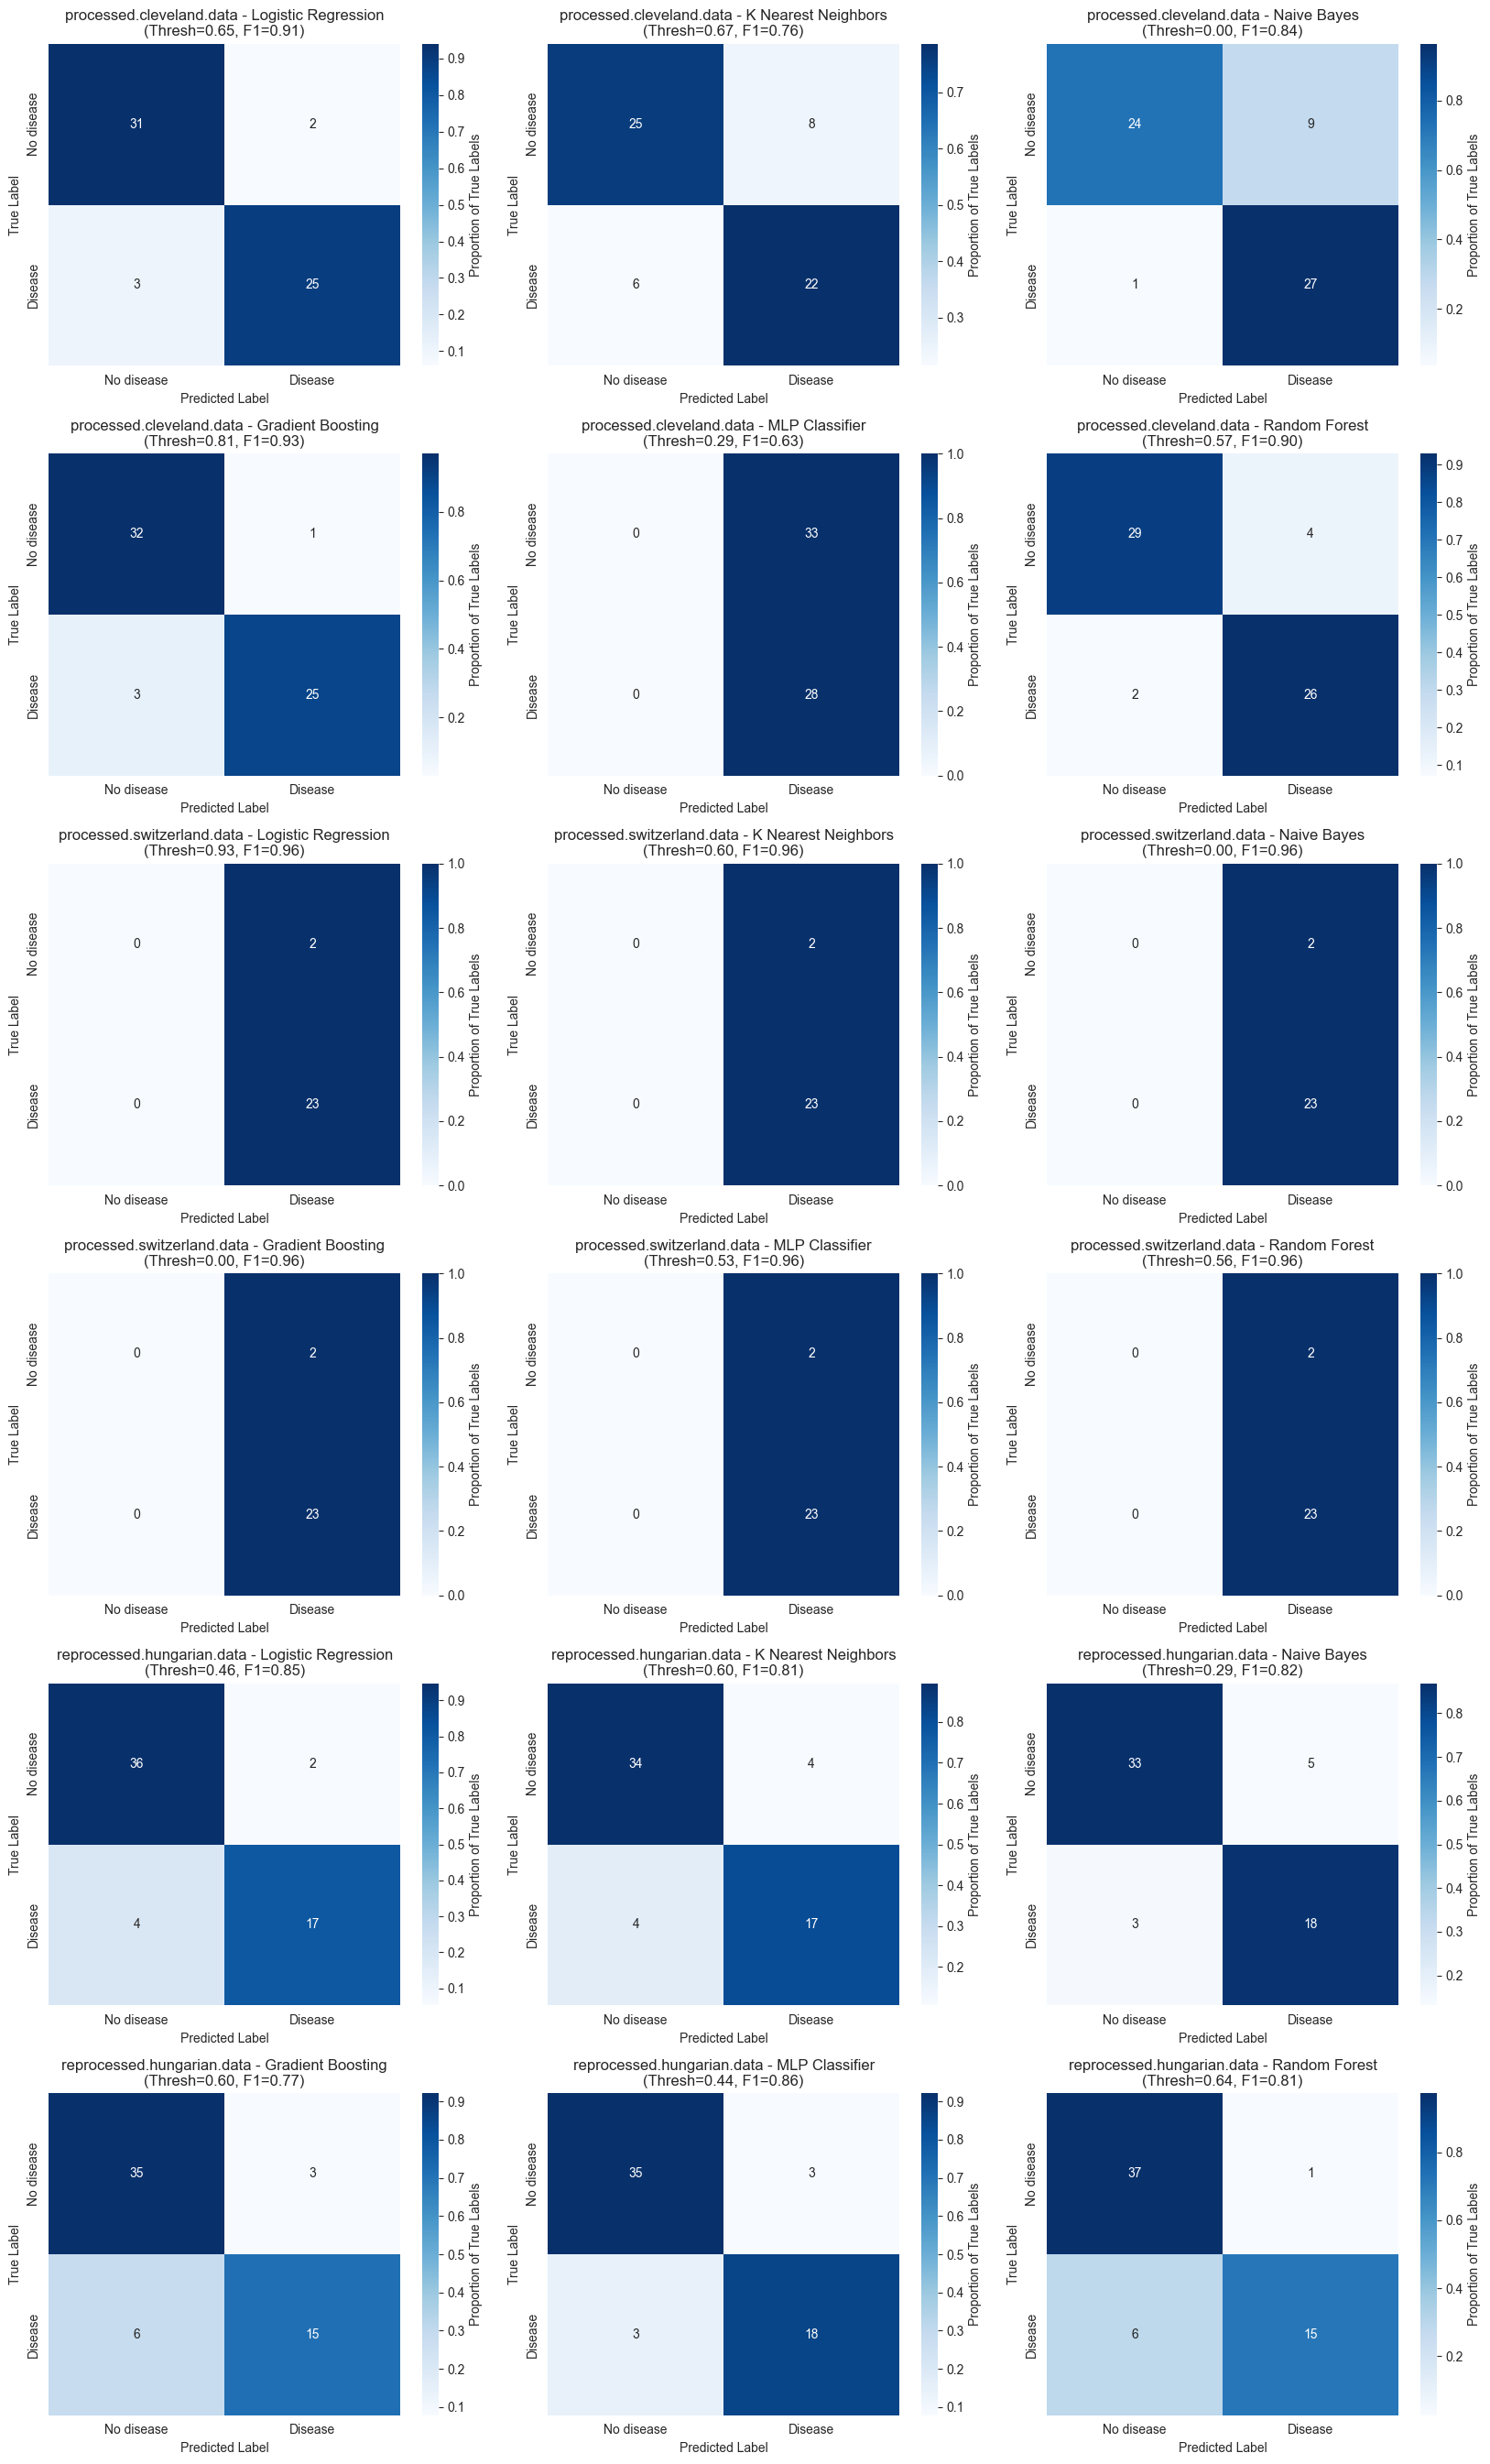

In [55]:
num_plots = len(detailed_classic_results)
cols = 3  
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 4.5))
axes_flat = axes.flatten() 

for idx, res in enumerate(detailed_classic_results):
    ax = axes_flat[idx]
    cm = res["Confusion Matrix"]
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis] 
    cm_norm = np.nan_to_num(cm_norm) 

    sns.heatmap(
        cm_norm,
        annot=cm, 
        fmt='d',  
        cmap='Blues',
        xticklabels=['No disease', 'Disease'],
        yticklabels=['No disease', 'Disease'],
        ax=ax,
        cbar=True, 
        cbar_kws={'label': 'Proportion of True Labels'}
    )
    ax.set_title(f'{res["Dataset"]} - {res["Model"]}\n(Thresh={res["Optimized Threshold"]:.2f}, F1={res["F1-Score (Class 1, Opt Thresh)"]:.2f})')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

for i in range(num_plots, rows * cols):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

**Confusion Matrix Interpretation:**
- Analyze True Positives (correctly predicted disease), True Negatives (correctly predicted no disease), False Positives (Type I error, predicted disease but no disease), and False Negatives (Type II error, predicted no disease but has disease).
- For heart disease prediction, False Negatives are often more critical to minimize.

#### 8.2.2. Precision-Recall (P-R) Curves
P-R curves are particularly useful for evaluating binary classifiers on imbalanced datasets. They plot Precision (Positive Predictive Value) against Recall (True Positive Rate or Sensitivity) at various threshold settings.
- A model that is closer to the top-right corner (Precision=1, Recall=1) is better.
- The point on the curve corresponding to the optimized F1-score (found in section 7.2) is marked with a scatter point.

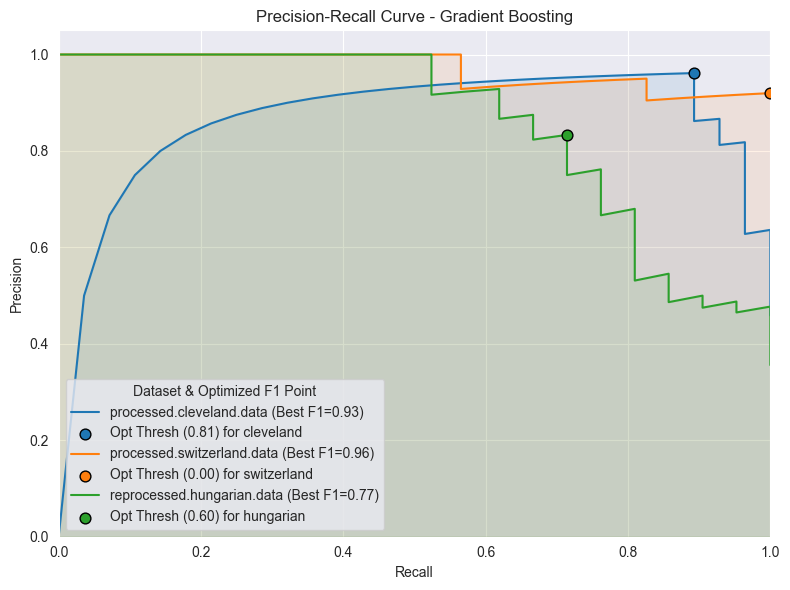

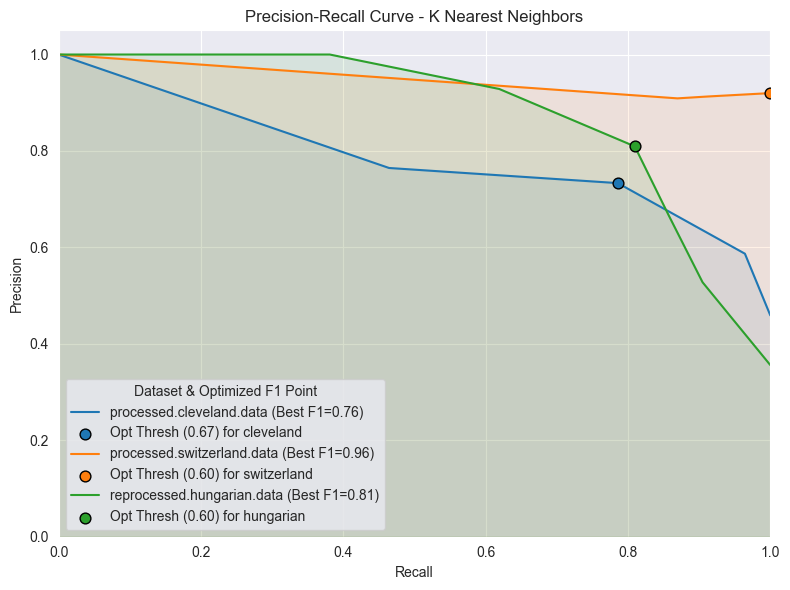

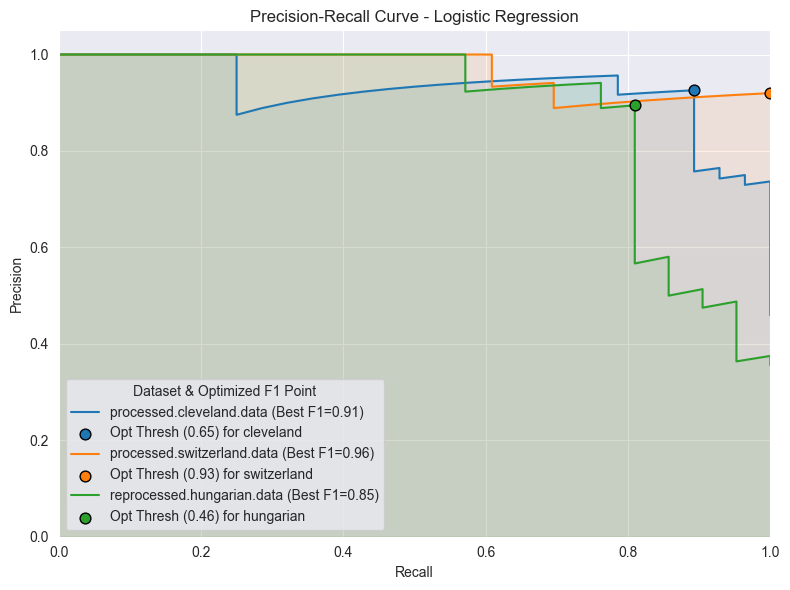

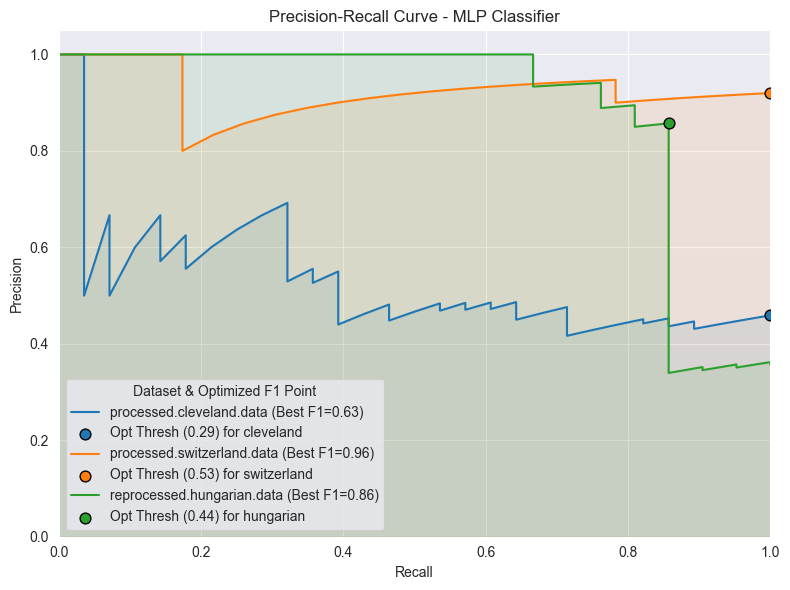

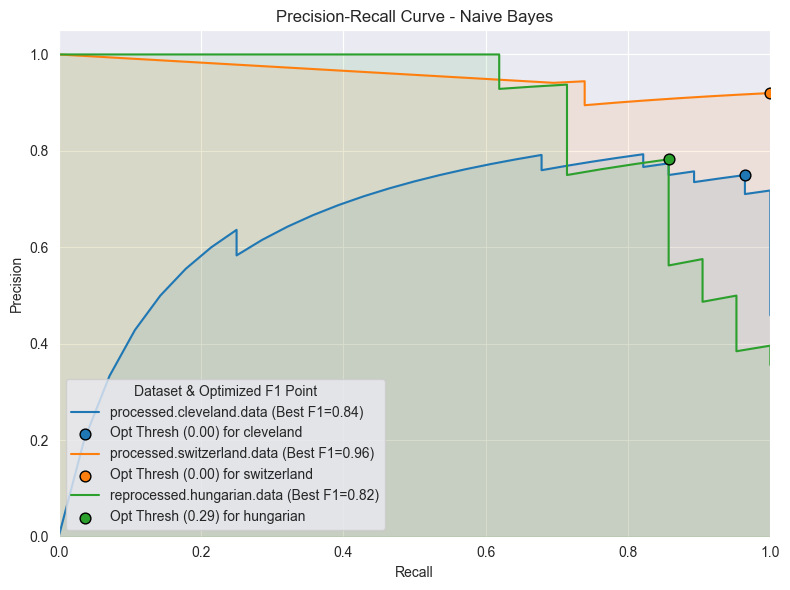

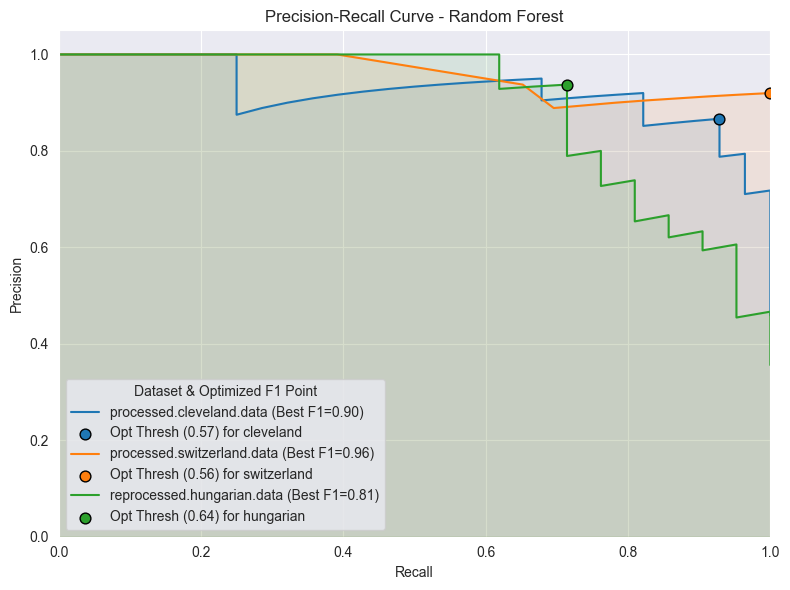

In [56]:
palette = sns.color_palette("tab10")
models_for_pr_curve = sorted(list(set(res["Model"] for res in detailed_classic_results)))

for model_name_pr in models_for_pr_curve:
    plt.figure(figsize=(8, 6))
    model_specific_results = [res for res in detailed_classic_results if res["Model"] == model_name_pr]

    for i, res in enumerate(model_specific_results):
        dataset_name_pr = res["Dataset"]
        
        precisions = res["precisions_pr"]
        recalls = res["recalls_pr"]
        current_f1 = res["F1-Score (Class 1, Opt Thresh)"]
        
        f1_options = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
        if len(f1_options) > len(res.get("thresholds_pr", recalls[:-1])):
            best_idx_pr = np.argmax(f1_options[:-1])
        else:
            best_idx_pr = np.argmax(f1_options)

        plt.plot(recalls, precisions, label=f'{dataset_name_pr} (Best F1={current_f1:.2f})',
                 color=palette[i % len(palette)])

        plt.scatter(recalls[best_idx_pr], precisions[best_idx_pr], 
                    color=palette[i % len(palette)],
                    edgecolor='black', zorder=5, s=60, 
                    label=f'Opt Thresh ({res["Optimized Threshold"]:.2f}) for {dataset_name_pr.split(".")[1]}')

        plt.fill_between(recalls, precisions, alpha=0.1, color=palette[i % len(palette)])

    plt.title(f"Precision-Recall Curve - {model_name_pr}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.legend(title="Dataset & Optimized F1 Point", loc="lower left")
    plt.tight_layout()
    plt.show()

**P-R Curve Interpretation:**
- Higher area under the P-R curve (AUC-PR) generally indicates better performance.
- Observe how precision changes with recall for each model and dataset. Some models might maintain high precision at higher recall values, which is desirable.

#### 8.2.3. F1-Score Comparison (Bar Plot)
This bar plot visually compares the F1-scores (for the positive class) achieved by:
1. The **Classic Approach (with Threshold Optimization)** from section 7.2.
2. The mean F1-score from **Nested Cross-Validation** from section 7.1.

This helps in understanding both the performance on a specific test split (Classic) and a more generalizable performance estimate (Nested CV).

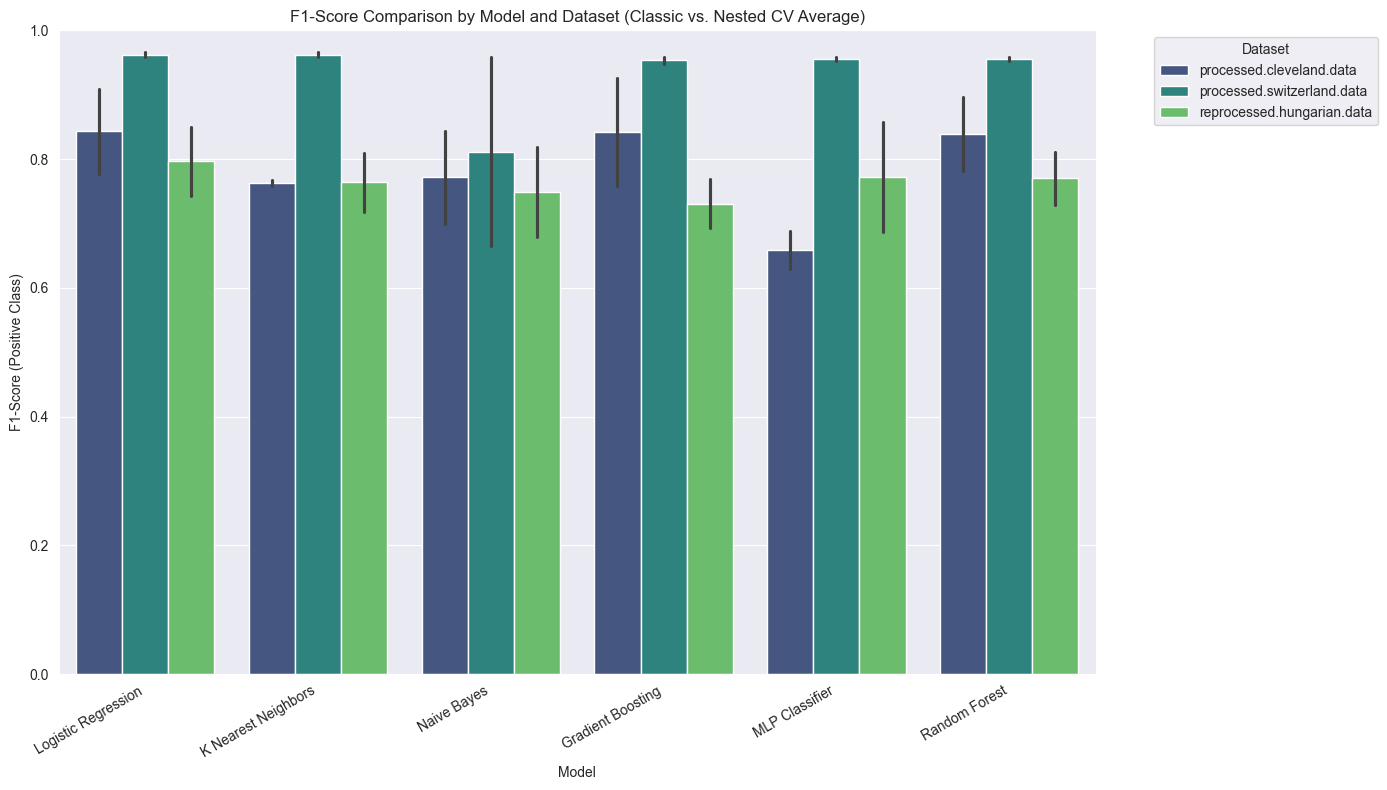

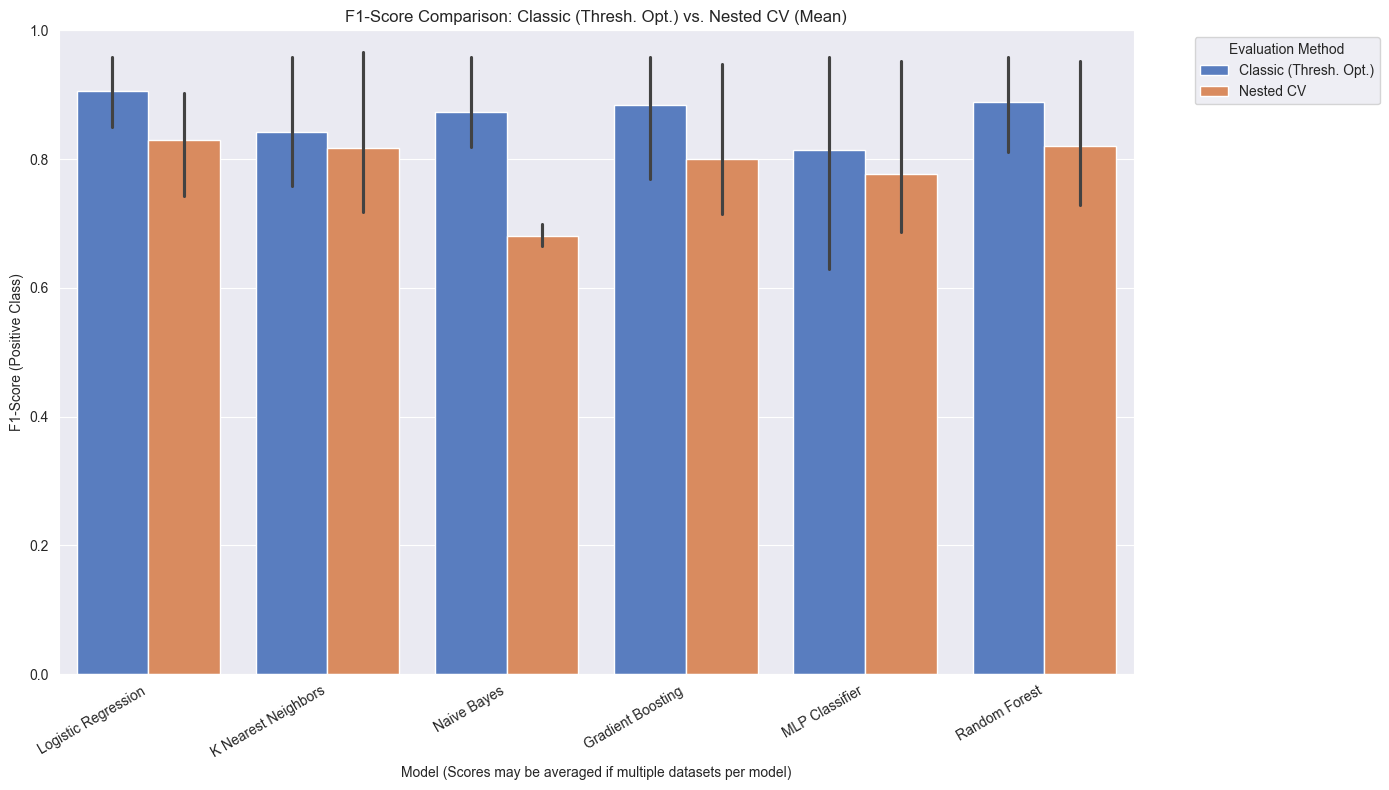

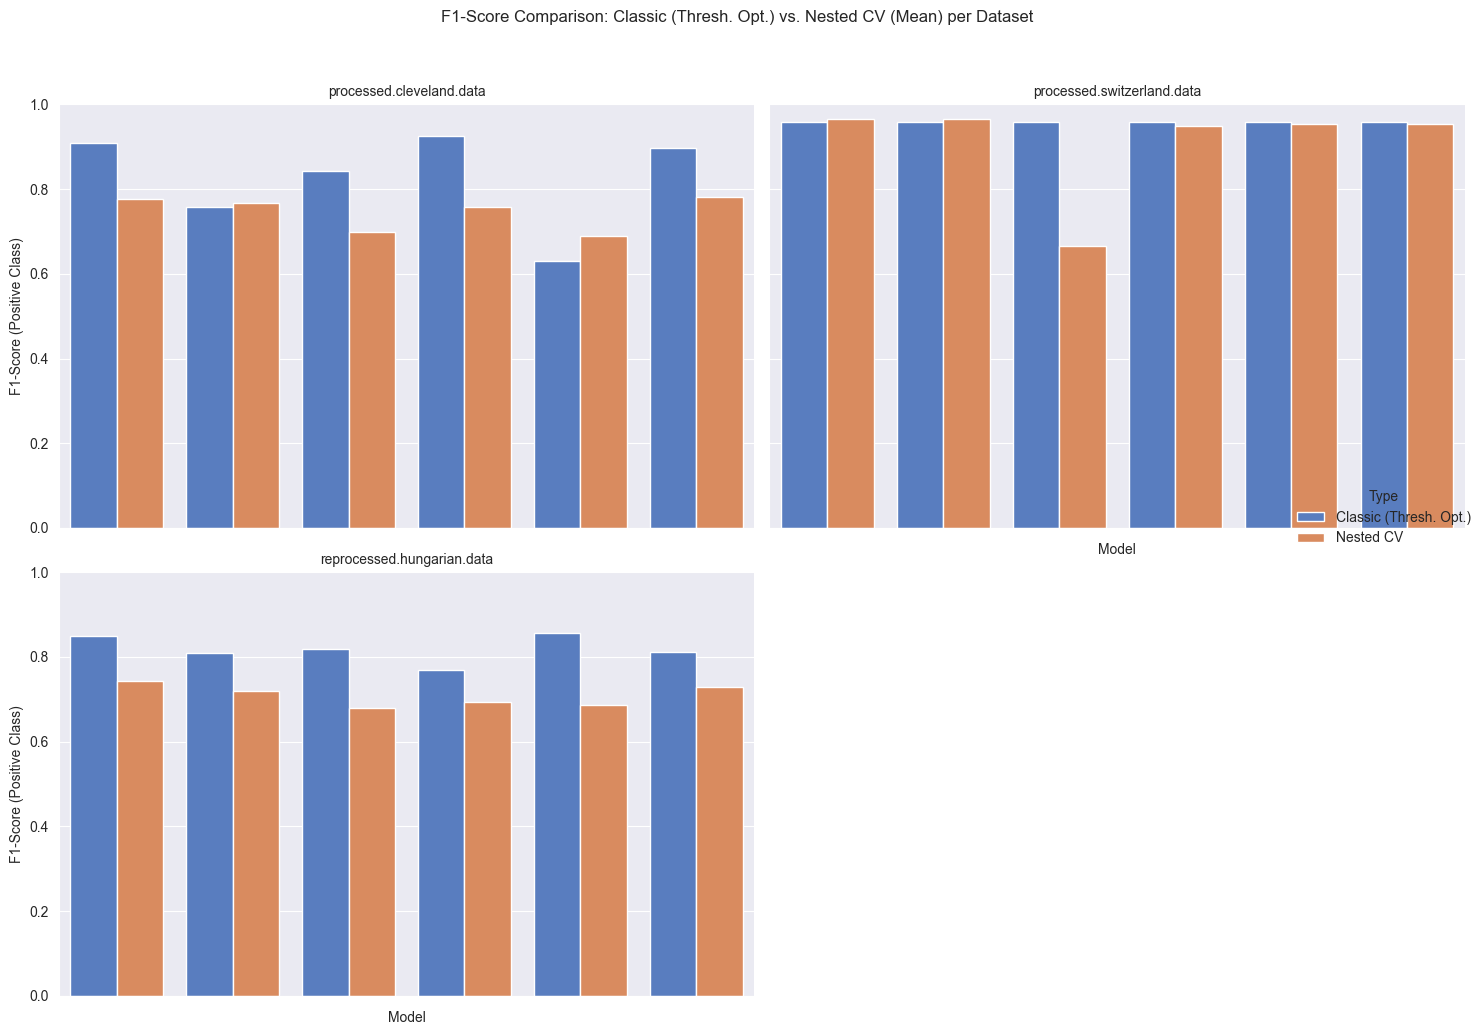

In [57]:
plt.figure(figsize=(14, 8)) 
sns.barplot(data=combined_f1_df_for_comparison, x="Model", y="F1-Score", hue="Dataset", palette="viridis")
plt.title("F1-Score Comparison by Model and Dataset (Classic vs. Nested CV Average)")
plt.ylabel("F1-Score (Positive Class)")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right") 
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(data=combined_f1_df_for_comparison, x="Model", y="F1-Score", hue="Type", palette="muted")
plt.title("F1-Score Comparison: Classic (Thresh. Opt.) vs. Nested CV (Mean)")
plt.ylabel("F1-Score (Positive Class)")
plt.xlabel("Model (Scores may be averaged if multiple datasets per model)")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.legend(title="Evaluation Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

g = sns.catplot(data=combined_f1_df_for_comparison, x="Model", y="F1-Score", hue="Type", col="Dataset", 
                kind="bar", palette="muted", col_wrap=2, height=5, aspect=1.3) 
g.set_titles("{col_name}")
g.set_axis_labels("Model", "F1-Score (Positive Class)")
g.set(ylim=(0,1))
g.set_xticklabels(rotation=45, ha="right") 
plt.suptitle("F1-Score Comparison: Classic (Thresh. Opt.) vs. Nested CV (Mean) per Dataset", y=1.03)
plt.tight_layout()
plt.show()

**Bar Plot Interpretation:**
- Visually compare which models and evaluation types yield higher F1-scores for each dataset.
- Differences between 'Classic (Thresh. Opt.)' and 'Nested CV' scores can highlight potential overfitting or the optimism introduced by optimizing and evaluating on the same test set in the classic approach.